In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
#!pip install -U xgboost -f /kaggle/input/xgboost-python-package/ --no-index

In [3]:
# !pip install kaggle --upgrade

In [4]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
DEBUG = False # False/True

In [6]:
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [7]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL); 

In [8]:
DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

In [9]:
# Location from https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [10]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

train data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical weather data has 1710802 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


forecast weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas prices data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data data has 75 rows and 3 columns. 
 ===> First row:


,county,longitude,latitude
0,0,24.2,59.1


In [11]:
# See county codes
with open(DATA_DIR + 'county_id_to_name_map.json') as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


# 데이터 전처리

In [12]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    # 데이터프레임의 열 이름을 변경
    # df : 변경할 열 이름이 있는 pandas 데이터프레임을 나타낸다.
    # suffix : 각 열 이름에 추가될 접미사를 나타낸다.
    # columns_no_change : 변경하지 않을 열 이름의 리스트를 나타낸다. 
    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        # # 시간 부분을 제거하고 날짜부분만 남긴다.
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        # 분기별로 나눈다
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        # 기상 데이터를 위치에 따라 그룹화한다.
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        # 다중 인덱스 열 이름을 단일 레벨로 평탄화한다.
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        # 열의 시간에 따라 1일 또는 2일 뒤로 조정한다. 
        # 오전 11시 이전(x['hour_h'] < 11)일 경우에는 1일을 더한다.
        # 오전 11시 이후일 경우에는 2일을 더한다.
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        # 평균 가스 가격
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df
        

In [13]:
# 주어진 데이터셋에 대해 과거의 목표값을 생성하고 기존 데이터셋에 병합하는 과정을 수행한다.
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

- 과거의 데이터가 오늘날 또는 미래에 중요한 정보를 제공할 수 있다.
- 현재 데이터에 과거의 정보를 추가함으로써 미래를 더 잘 예측할 수 있도록 돕는 역할을 한다.

In [14]:
%%time
# Create all features
N_day_lags = 15 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )
df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

CPU times: user 31.3 s, sys: 6.91 s, total: 38.2 s
Wall time: 38.3 s


In [15]:
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,2023,2,5,22,23,151,31,2,15.0,620.0,2023-05-29,11.18,6.98,0.0,0.0,1003.74,21.2,2.8,16.4,29.8,1.772222,170.0,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,188.167,173.048,184.072,188.122,356.783,415.530,182.342,459.845,162.786,186.582,191.756,181.415,421.707,410.259
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,2023,2,5,22,23,151,31,2,20.0,624.5,2023-05-29,11.18,6.98,0.0,0.0,1003.74,21.2,2.8,16.4,29.8,1.772222,170.0,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018349,15,1,

In [16]:
#### Create single fold split ######
# Remove empty target row
target = 'target'
df = df[df[target].notnull()].reset_index(drop=True)

train_block_id = list(range(0, 600)) 

tr = df[df['data_block_id'].isin(train_block_id)] # first 600 data_block_ids used for training
val = df[~df['data_block_id'].isin(train_block_id)] # rest data_block_ids used for validation

In [17]:
# remove_columns = []
# for col in df.columns:
    # for no_feature in no_features:
        # if no_feature in col:
            # remove_columns.append(col)
# Remove columns for features
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]           
remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]

In [18]:
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]
PrintColor(f'There are {len(features)} features: {features}')

There are 59 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [19]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 2 if DEBUG else 1500,
                        early_stopping_rounds=100
                       )

In [20]:
clf.fit(X = tr[features], 
        y = tr[target], 
        eval_set = [(tr[features], tr[target]), (val[features], val[target])], 
        verbose=True #False #True
       )

[0]	validation_0-mae:241.34684	validation_1-mae:313.59941
[1]	validation_0-mae:215.42566	validation_1-mae:280.99736
[2]	validation_0-mae:190.86719	validation_1-mae:251.46713
[3]	validation_0-mae:170.45290	validation_1-mae:226.12021
[4]	validation_0-mae:154.05879	validation_1-mae:206.42081
[5]	validation_0-mae:141.26333	validation_1-mae:191.22848
[6]	validation_0-mae:126.34718	validation_1-mae:173.50434
[7]	validation_0-mae:104.95939	validation_1-mae:149.12590
[8]	validation_0-mae:90.21020	validation_1-mae:130.32305
[9]	validation_0-mae:79.70725	validation_1-mae:118.30661
[10]	validation_0-mae:72.94622	validation_1-mae:111.31507
[11]	validation_0-mae:68.00842	validation_1-mae:105.99575
[12]	validation_0-mae:63.90158	validation_1-mae:102.58870
[13]	validation_0-mae:61.31166	validation_1-mae:101.00590
[14]	validation_0-mae:59.39358	validation_1-mae:99.67466
[15]	validation_0-mae:58.39937	validation_1-mae:98.37546
[16]	validation_0-mae:57.30846	validation_1-mae:97.14324
[17]	validation_0-m

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [21]:
PrintColor(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')

Early stopping on best iteration #345 with MAE error on validation set of 73.60


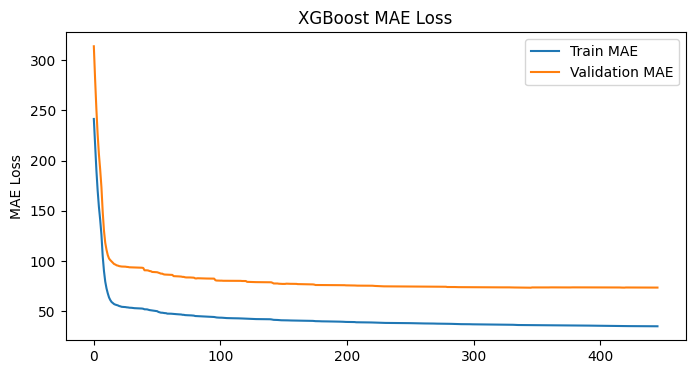

In [22]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train MAE")
ax.plot(x_values, val_mae, label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.title("XGBoost MAE Loss")
plt.show()

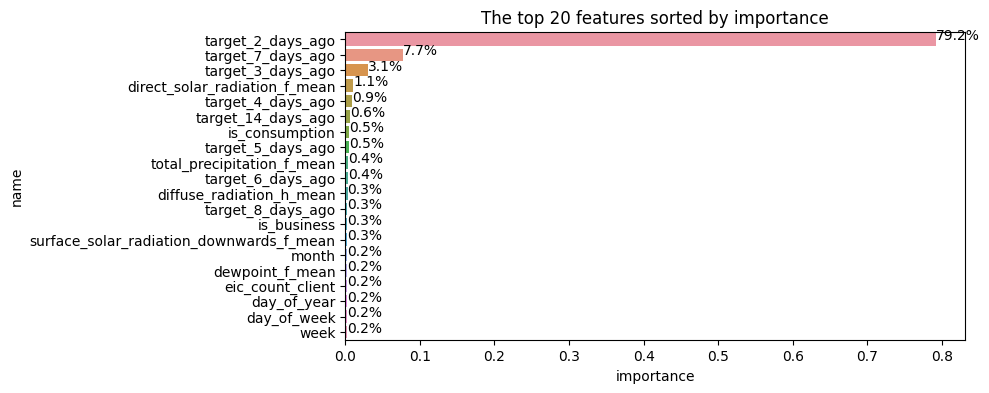

In [23]:
TOP = 20
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [24]:
importance_data[importance_data['importance']<0.0005].name.values

array(['euros_per_mwh_electricity', 'cloudcover_high_f_mean',
       'cloudcover_mid_f_mean', 'surface_pressure_h_mean',
       'cloudcover_total_h_mean', '10_metre_v_wind_component_f_mean',
       'winddirection_10m_h_mean', 'cloudcover_mid_h_mean',
       'windspeed_10m_h_mean', 'cloudcover_high_h_mean', 'rain_h_mean',
       'snowfall_h_mean'], dtype=object)

# Submit

In [25]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime']).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

In [26]:
import enefit
enefit.make_env.func_dict['__called__'] = False
env = enefit.make_env()
iter_test = env.iter_test()

In [27]:
# Reload enefit environment (only in debug mode, otherwise the submission will fail)
if DEBUG:
    enefit.make_env.__called__ = False
    type(env)._state = type(type(env)._state).__dict__['INIT']
    iter_test = env.iter_test()

In [28]:
# List of target_revealed dataframes
previous_revealed_targets = []

for (test, 
     revealed_targets, 
     client_test, 
     historical_weather_test,
     forecast_weather_test, 
     electricity_test, 
     gas_test, 
     sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})

    # Initiate column data_block_id with default value to join on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = FeatureProcessor(
                               data = test,
                               client = client_test, 
                               historical_weather = historical_weather_test,
                               forecast_weather = forecast_weather_test, 
                               electricity = electricity_test, 
                               gas = gas_test
                               )
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    
    # Make prediction
    X_test = df_test[features]
    sample_prediction['target'] = clf.predict(X_test)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:55:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [29]:
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = 0
    env.predict(sample_prediction_df)